# March Madness - WAE

The overall question I am trying to answer is which teams over performed their expected wins the most for each tournament and over that entire time frame of my data. To do that, I am going to create a linear regression model that takes in a set of feature metrics from the datasets below, and outputs a predicted number of NCAA tournament wins (it takes 6 wins to win the NCAA Tournament). Then, for each tournament team, I will calculate the Wins Above Expected (WAE) by subtracting the actual wins from the predicted wins.

My statistical data is coming from Ken Pomeroy's rankings which has advanced statistics and adjusted efficiencies for each team going back to 2003.
I'm using this data and then the Kaggle information about the tournament matchup history and win totals to determine which teams most over/(under)performed expectations in each tournament.
Because the team information is different between the two datasets, I had to create a custom Team ID list ('TeamsStandard.csv' below).

### Caveats:
The Ken Pomeroy data includes tournament games in the historical overall season data, but given the amount of data and the fact that it is adjusted over an entire season, I'm willing to tolerate that.

The team names are not consistent across the datasets so I needed to adjust those and then assign the ID to each Ken Pomeroy Team row.

My data currently only goes through the 2015 tournament because I couldn't pull the 2016 or 2017 data from Kaggle for tournament team wins.

## Getting and Cleaning the Data
I have to scrape the KenPom data, because I don't have a subscription. The Kaggle data I was able to download as csv from their website for a past March Madness competition.

In [1]:
# import libraries necessary for scraping the kenpom data

from bs4 import BeautifulSoup
import urllib
import re
import pandas as pd
import numpy as np

In [2]:
def import_kp(year):
    # go to kenpom and scrape the yearly data
    url = "https://kenpom.com/index.php?y=" + str(year)
    html = urllib.request.urlopen(url).read()
    
    # get rid of the thead info to isolate just the table of data
    soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")
    table_html = soup.find_all('table', {'id': 'ratings-table'})
    thead = table_html[0].find_all('thead')
    table = table_html[0]
    for x in thead:
        table = str(table).replace(str(x),'')
    
    # create kp_year data frame using the table of data
    kp_year = pd.read_html(table)[0]
    kp_year['Year'] = year
    return kp_year
    

In [3]:
years = range(2003,2017)

In [4]:
# create a single dataframe that contains the data for every year in the range of 'years'
kenpomraw = pd.DataFrame()
for i in years:
    kenpomraw = pd.concat((kenpomraw, import_kp(i)), axis=0)

In [5]:
kenpomraw.shape

(4775, 22)

In [6]:
# rename the columns to match the website

kenpomraw.columns = ['Rank', 'Team', 'Conference', 'W-L', 'AdjustEM', 
             'AdjustO', 'AdjustO Rank', 'AdjustD', 'AdjustD Rank',
             'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank', 
             'SOS AdjustEM', 'SOS AdjustEM Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS AdjustEM', 'NCSOS AdjustEM Rank', 'Year']

In [7]:
# clean up the teams/seeds and W-L record columns

valid_seed = lambda x: True if str(x).replace(' ', '').isdigit() and int(x) > 0 and int(x) <= 16 else False
kenpomraw['Seed'] = kenpomraw['Team'].apply(lambda x: x[-2:].replace(' ', '') if valid_seed(x[-2:]) else np.nan)
kenpomraw['Team'] = kenpomraw['Team'].apply(lambda x: x[:-2] if valid_seed(x[-2:]) else x)

kenpomraw['Wins'] = kenpomraw['W-L'].apply(lambda x: int(re.sub('-.*', '', x)) )
kenpomraw['Losses'] = kenpomraw['W-L'].apply(lambda x: int(re.sub('.*-', '', x)) )
kenpomraw.drop('W-L', inplace=True, axis=1)

In [8]:
kenpomraw.tail()

,Rank,Team,Conference,AdjustEM,AdjustO,AdjustO Rank,AdjustD,AdjustD Rank,AdjustT,AdjustT Rank,...,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank,Year,Seed,Wins,Losses
346,347,Chicago St.,WAC,-22.21,91.8,338,114.0,327,69.0,118,...,103.9,201,104.3,131,4.42,48,2016,NaN,4,28
347,348,UT Rio Grande Valley,WAC,-22.36,95.1,322,117.4,345,67.5,209,...,102.0,283,106.5,218,-1.75,214,2016,NaN,8,22
348,349,Florida A&M;,MEAC,-24.58,83.7,351,108.3,239,69.4,106,...,99.4,336,110.5,351,-4.23,285,2016,NaN,8,21
349,350,Delaware St.,MEAC,-24.71,88.5,346,113.3,321,66.2,266,...,100.4,322,107.8,283,5.28,33,2016,NaN,7,25
350,351,Central Connecticut,NEC,-26.79,92.5,333,119.3,351,67.0,235,...,98.2,350,108.7,326,-6.75,321,2016,NaN,4,25


In [9]:
kenpomraw.shape

(4775, 24)

In [10]:
# get rid of trailing whitespace in team names
kenpomraw['Team'] = kenpomraw.Team.apply(lambda x: x.rstrip())

# a few of the team names also had ';' in them
kenpomraw['Team'] = kenpomraw.Team.apply(lambda x: x.replace(';',''))

In [11]:
kenpomraw.tail()

,Rank,Team,Conference,AdjustEM,AdjustO,AdjustO Rank,AdjustD,AdjustD Rank,AdjustT,AdjustT Rank,...,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank,Year,Seed,Wins,Losses
346,347,Chicago St.,WAC,-22.21,91.8,338,114.0,327,69.0,118,...,103.9,201,104.3,131,4.42,48,2016,NaN,4,28
347,348,UT Rio Grande Valley,WAC,-22.36,95.1,322,117.4,345,67.5,209,...,102.0,283,106.5,218,-1.75,214,2016,NaN,8,22
348,349,Florida A&M,MEAC,-24.58,83.7,351,108.3,239,69.4,106,...,99.4,336,110.5,351,-4.23,285,2016,NaN,8,21
349,350,Delaware St.,MEAC,-24.71,88.5,346,113.3,321,66.2,266,...,100.4,322,107.8,283,5.28,33,2016,NaN,7,25
350,351,Central Connecticut,NEC,-26.79,92.5,333,119.3,351,67.0,235,...,98.2,350,108.7,326,-6.75,321,2016,NaN,4,25


In [12]:
# saved the overall dataframe as a csv in case I lost the internet again
kenpomraw.to_csv('kenpom_03-16.csv')

In [ ]:
# kenpomraw = pd.read_csv('kenpom_03-16.csv')

In [ ]:
# bring in the Team_Id info about tournament games
# the Kaggle Teams.csv file was edited in order to sync up with the kenpom team names

In [13]:
Teams = pd.read_csv('TeamsStandard.csv')

In [14]:
Teams.tail()

,Team_Id,Team_Name
368,1460,Wright St.
369,1461,Wyoming
370,1462,Xavier
371,1463,Yale
372,1464,Youngstown St.


In [15]:
# merge kenpom and Teams in order to track the Team_Id from the Kaggle data
Teams.rename(columns={'Team_Name':'Team'},inplace=True)
kenpom = kenpomraw.merge(Teams, on='Team',how='left')

In [16]:
kenpom.tail()

,Rank,Team,Conference,AdjustEM,AdjustO,AdjustO Rank,AdjustD,AdjustD Rank,AdjustT,AdjustT Rank,...,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank,Year,Seed,Wins,Losses,Team_Id
4784,347,Chicago St.,WAC,-22.21,91.8,338,114.0,327,69.0,118,...,201,104.3,131,4.42,48,2016,NaN,4,28,1152
4785,348,UT Rio Grande Valley,WAC,-22.36,95.1,322,117.4,345,67.5,209,...,283,106.5,218,-1.75,214,2016,NaN,8,22,1410
4786,349,Florida A&M,MEAC,-24.58,83.7,351,108.3,239,69.4,106,...,336,110.5,351,-4.23,285,2016,NaN,8,21,1197
4787,350,Delaware St.,MEAC,-24.71,88.5,346,113.3,321,66.2,266,...,322,107.8,283,5.28,33,2016,NaN,7,25,1175
4788,351,Central Connecticut,NEC,-26.79,92.5,333,119.3,351,67.0,235,...,350,108.7,326,-6.75,321,2016,NaN,4,25,1148


In [17]:
# check for nulls
kenpom[kenpom.Team_Id.isnull()].Team.value_counts()

Series([], Name: Team, dtype: int64)

In [18]:
kenpom.columns

Index(['Rank', 'Team', 'Conference', 'AdjustEM', 'AdjustO', 'AdjustO Rank',
       'AdjustD', 'AdjustD Rank', 'AdjustT', 'AdjustT Rank', 'Luck',
       'Luck Rank', 'SOS AdjustEM', 'SOS AdjustEM Rank', 'SOS OppO',
       'SOS OppO Rank', 'SOS OppD', 'SOS OppD Rank', 'NCSOS AdjustEM',
       'NCSOS AdjustEM Rank', 'Year', 'Seed', 'Wins', 'Losses', 'Team_Id'],
      dtype='object')

In [19]:
kenpom = kenpom [['Year','Rank','Team','Team_Id','Conference','Wins','Losses','Seed','AdjustEM','AdjustO',
                 'AdjustO Rank','AdjustD','AdjustD Rank','AdjustT','AdjustT Rank','Luck','Luck Rank',
                 'SOS AdjustEM','SOS AdjustEM Rank','SOS OppO','SOS OppO Rank','SOS OppD','SOS OppD Rank',
                 'NCSOS AdjustEM','NCSOS AdjustEM Rank']]

In [20]:
kenpom.head()

,Year,Rank,Team,Team_Id,Conference,Wins,Losses,Seed,AdjustEM,AdjustO,...,Luck,Luck Rank,SOS AdjustEM,SOS AdjustEM Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank
0,2003,1,Kentucky,1246,SEC,32,4,1,29.18,116.5,...,0.051,53,11.20,4,108.6,3,97.4,16,6.77,33
1,2003,2,Kansas,1242,B12,30,8,2,28.62,115.0,...,-0.017,208,11.84,2,108.7,2,96.8,9,6.08,35
2,2003,3,Pittsburgh,1338,BE,28,5,2,28.61,114.8,...,-0.023,224,7.07,56,105.5,66,98.4,49,-8.24,310
3,2003,4,Arizona,1112,P10,28,4,1,26.80,115.6,...,-0.007,181,8.69,31,107.2,14,98.5,53,8.19,26
4,2003,5,Illinois,1228,B10,25,7,4,24.47,113.2,...,-0.029,242,7.29,52,105.8,59,98.5,54,-4.18,257


### Separate out just the tournament teams
Reduce the dataframes to only contain teams that actually made the tournament each year. Then merge the number of tournament wins that team had that year (it takes 6 wins to win the championship).

In [21]:
TourneyTeams = pd.DataFrame(kenpom)

In [22]:
# drop rows for teams that didn't make the tournament
TourneyTeams.dropna(axis=0, inplace=True)

In [23]:
TourneyTeams.tail()

,Year,Rank,Team,Team_Id,Conference,Wins,Losses,Seed,AdjustEM,AdjustO,...,Luck,Luck Rank,SOS AdjustEM,SOS AdjustEM Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank
4653,2016,217,Austin Peay,1122,OVC,18,18,16,-5.10,104.5,...,0.061,43,-2.92,213,105.1,149,108.0,292,-0.19,170
4665,2016,229,Southern,1380,SWAC,22,13,16,-5.75,100.5,...,0.040,83,-8.52,332,99.1,340,107.6,273,3.49,70
4684,2016,248,Hampton,1214,MEAC,21,11,16,-7.40,99.8,...,0.157,2,-9.75,341,98.9,342,108.7,325,1.91,112
4716,2016,280,Fairleigh Dickinson,1192,NEC,18,15,16,-10.63,104.4,...,0.097,16,-9.44,338,98.7,345,108.1,299,-0.17,169
4721,2016,285,Holy Cross,1221,Pat,15,20,16,-11.39,97.1,...,0.065,39,-6.09,290,101.9,288,108.0,294,-6.27,313


In [24]:
TourneyTeams.reset_index(inplace=True)

In [25]:
TourneyTeams.shape

(931, 26)

In [26]:
# calculate the tournament wins by team per year

In [27]:
TourneyResults = pd.read_csv('TourneyCompactResults.csv')

In [28]:
TourneyResults.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [29]:
# get rid of the play in games; I don't want those to count as wins for the play-in teams
TourneyResults = TourneyResults[TourneyResults.Daynum >= 136]

In [30]:
wins = TourneyResults.drop(['Wscore','Lscore','Lteam','Wloc','Numot'], axis=1)

In [31]:
def tournament_wins(year):
    yearly_wins = wins[wins.Season == year].groupby('Wteam').Daynum.count()
    yearly_win_df = pd.DataFrame(yearly_wins)
    yearly_win_df.reset_index()
    yearly_win_df['Season'] = year
    return yearly_win_df


In [32]:
years = range(2003,2016)
df = pd.DataFrame()
for i in years:
    df = pd.concat((df, tournament_wins(i)), axis=0)
df.reset_index(inplace=True)
df.rename(columns={'Daynum':'Tourn_wins','Wteam':'Team_Id','Season':'Year'},inplace=True)
df.head()

,Team_Id,Tourn_wins,Year
0,1112,3,2003
1,1113,1,2003
2,1120,2,2003
3,1139,2,2003
4,1141,1,2003


In [33]:
df.shape

(416, 3)

In [34]:
TourneyTeams.tail()

,index,Year,Rank,Team,Team_Id,Conference,Wins,Losses,Seed,AdjustEM,...,Luck,Luck Rank,SOS AdjustEM,SOS AdjustEM Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank
926,4653,2016,217,Austin Peay,1122,OVC,18,18,16,-5.10,...,0.061,43,-2.92,213,105.1,149,108.0,292,-0.19,170
927,4665,2016,229,Southern,1380,SWAC,22,13,16,-5.75,...,0.040,83,-8.52,332,99.1,340,107.6,273,3.49,70
928,4684,2016,248,Hampton,1214,MEAC,21,11,16,-7.40,...,0.157,2,-9.75,341,98.9,342,108.7,325,1.91,112
929,4716,2016,280,Fairleigh Dickinson,1192,NEC,18,15,16,-10.63,...,0.097,16,-9.44,338,98.7,345,108.1,299,-0.17,169
930,4721,2016,285,Holy Cross,1221,Pat,15,20,16,-11.39,...,0.065,39,-6.09,290,101.9,288,108.0,294,-6.27,313


In [35]:
tournament_winners = TourneyTeams.merge(df, on=['Team_Id','Year'],how='left')

In [36]:
# fill the null win rows with 0
tournament_winners.fillna(value=0,inplace=True)

In [37]:
bonus = tournament_winners[tournament_winners.Year > 2015]

In [38]:
tournament_winners = tournament_winners[tournament_winners.Year < 2016]

In [39]:
tournament_winners.Seed = pd.to_numeric(tournament_winners.Seed, errors='coerce')

In [40]:
tournament_winners.shape

(863, 27)

In [41]:
tournament_winners.head()

,index,Year,Rank,Team,Team_Id,Conference,Wins,Losses,Seed,AdjustEM,...,Luck Rank,SOS AdjustEM,SOS AdjustEM Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank,Tourn_wins
0,0,2003,1,Kentucky,1246,SEC,32,4,1,29.18,...,53,11.20,4,108.6,3,97.4,16,6.77,33,3.0
1,1,2003,2,Kansas,1242,B12,30,8,2,28.62,...,208,11.84,2,108.7,2,96.8,9,6.08,35,5.0
2,2,2003,3,Pittsburgh,1338,BE,28,5,2,28.61,...,224,7.07,56,105.5,66,98.4,49,-8.24,310,2.0
3,3,2003,4,Arizona,1112,P10,28,4,1,26.80,...,181,8.69,31,107.2,14,98.5,53,8.19,26,3.0
4,4,2003,5,Illinois,1228,B10,25,7,4,24.47,...,242,7.29,52,105.8,59,98.5,54,-4.18,257,1.0


## Feature Selection and Model Building
I used test-train-split for flexibility and speed.

In [42]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Feature set Comparison

In [43]:
# compare feature sets
def train_test_rmse(feature_cols):
    X = tournament_winners[feature_cols]
    y = tournament_winners.Tourn_wins
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [44]:
print(train_test_rmse(['AdjustEM','SOS AdjustEM']))
print(train_test_rmse(['AdjustT','Wins']))
print(train_test_rmse(['AdjustEM','AdjustT','Wins']))
print(train_test_rmse(['AdjustEM','SOS AdjustEM','AdjustT','Wins','SOS AdjustEM']))
print(train_test_rmse(['Rank','Wins','Losses','Seed','AdjustEM','AdjustO',
                 'AdjustO Rank','AdjustD','AdjustD Rank','AdjustT','AdjustT Rank','Luck','Luck Rank',
                 'SOS AdjustEM','SOS AdjustEM Rank','SOS OppO','SOS OppO Rank','SOS OppD','SOS OppD Rank',
                 'NCSOS AdjustEM','NCSOS AdjustEM Rank']))
print(train_test_rmse(['Wins','Losses','Seed','AdjustEM','AdjustO',
                 'AdjustD','AdjustT','Luck',
                 'SOS AdjustEM','SOS OppO','SOS OppD',
                 'NCSOS AdjustEM']))
print(train_test_rmse(['Rank','Wins','Losses','Seed',
                 'AdjustO Rank','AdjustD Rank','AdjustT Rank','Luck Rank',
                 'SOS AdjustEM Rank','SOS OppO Rank','SOS OppD Rank',
                 'NCSOS AdjustEM Rank']))
print(train_test_rmse(['Wins','Losses']))
print(train_test_rmse(['Seed']))

1.11049116387
1.03168053339
0.987329325455
0.930952781934
0.835283807856
0.892489127761
0.876803477409
0.956237567556
1.1526280291


In [47]:
# what is the null RMSE?
y_actual = tournament_winners.Tourn_wins
y_null = np.zeros_like(y_actual, dtype=float)
y_null.fill(y_actual.mean())
np.sqrt(metrics.mean_squared_error(y_actual, y_null))

1.3287779445644037

#### Build Linear Regression Model

In [48]:
# I've chosen to use the feature set that includes the most information (uses all of the kenpom columns) and 
# has the lowest RMSE

In [49]:
features = ['Rank','Wins','Losses','Seed','AdjustEM','AdjustO','AdjustO Rank','AdjustD','AdjustD Rank',
            'AdjustT','AdjustT Rank','Luck','Luck Rank','SOS AdjustEM','SOS AdjustEM Rank','SOS OppO',
            'SOS OppO Rank','SOS OppD','SOS OppD Rank','NCSOS AdjustEM','NCSOS AdjustEM Rank']

In [50]:
# back up feature set that doesn't include rank columns
# features = ['Wins','Losses','Seed','AdjustEM','AdjustO','AdjustD',
#             'AdjustT','Luck','SOS AdjustEM','SOS OppO',
#             'SOS OppD','NCSOS AdjustEM']

In [51]:
X = tournament_winners[features]
y = tournament_winners.Tourn_wins
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [52]:
tournament_winners['Expected'] = linreg.predict(tournament_winners[features])

In [53]:
tournament_winners.head()

,index,Year,Rank,Team,Team_Id,Conference,Wins,Losses,Seed,AdjustEM,...,SOS AdjustEM,SOS AdjustEM Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank,Tourn_wins,Expected
0,0,2003,1,Kentucky,1246,SEC,32,4,1,29.18,...,11.20,4,108.6,3,97.4,16,6.77,33,3.0,3.729942
1,1,2003,2,Kansas,1242,B12,30,8,2,28.62,...,11.84,2,108.7,2,96.8,9,6.08,35,5.0,3.691952
2,2,2003,3,Pittsburgh,1338,BE,28,5,2,28.61,...,7.07,56,105.5,66,98.4,49,-8.24,310,2.0,2.227748
3,3,2003,4,Arizona,1112,P10,28,4,1,26.80,...,8.69,31,107.2,14,98.5,53,8.19,26,3.0,2.214520
4,4,2003,5,Illinois,1228,B10,25,7,4,24.47,...,7.29,52,105.8,59,98.5,54,-4.18,257,1.0,1.215171


In [54]:
WAE = tournament_winners[['Year','Team','Seed','Tourn_wins','Expected','Conference','Luck', 'SOS AdjustEM Rank']]

In [55]:
WAE['WAE'] = WAE.Tourn_wins - WAE.Expected

/Users/jamesbrideau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
linreg.coef_

array([  2.46057968e-02,   2.51446770e-01,   1.20458257e-01,
         2.76653184e-02,  -2.12725607e-01,   3.25351615e-01,
        -3.53743655e-03,  -3.26406814e-01,  -3.05946413e-03,
         8.06994915e-02,   2.19576964e-03,  -5.70735288e+00,
        -3.84994808e-03,   5.55173504e-01,   5.57498570e-04,
        -4.94010072e-01,  -6.76970769e-04,   3.67213537e-01,
         1.19218787e-03,  -4.01248440e-02,  -2.44671698e-03])

## Analysis of Results

In [57]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

%matplotlib inline

In [58]:
WAE.sort_values(by='WAE',ascending=False).head(20)

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
7,2003,Syracuse,3,6.0,2.842235,BE,0.083,10,3.157765
554,2011,Butler,8,5.0,2.077810,Horz,0.033,57,2.922190
741,2014,Connecticut,7,6.0,3.167972,Amer,0.080,13,2.832028
215,2006,George Mason,11,4.0,1.347835,CAA,0.017,88,2.652165
195,2006,Florida,3,6.0,3.355178,SEC,-0.011,24,2.644822
66,2004,Connecticut,2,6.0,3.575630,BE,0.012,18,2.424370
134,2005,Michigan St.,5,4.0,1.576304,B10,-0.013,33,2.423696
14,2003,Marquette,3,4.0,1.593817,CUSA,0.070,42,2.406183
92,2004,Alabama,8,3.0,0.744717,SEC,0.004,8,2.255283
739,2014,Kentucky,8,5.0,2.751442,SEC,-0.025,5,2.248558


In [59]:
WAE.sort_values(by='WAE',ascending=True).head(20)

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
456,2010,Kansas,1,1.0,3.850831,B12,0.038,16,-2.850831
799,2015,Villanova,1,1.0,3.299350,BE,0.031,41,-2.299350
680,2013,New Mexico,3,0.0,2.030117,MWC,0.073,25,-2.030117
520,2011,Ohio St.,1,2.0,3.870571,B10,0.031,26,-1.870571
595,2012,Missouri,2,0.0,1.749079,B12,0.017,51,-1.749079
501,2010,Richmond,7,0.0,1.732872,A10,0.047,70,-1.732872
475,2010,Temple,5,0.0,1.711495,A10,0.076,67,-1.711495
400,2009,West Virginia,6,0.0,1.704609,BE,-0.067,8,-1.704609
662,2013,Gonzaga,1,1.0,2.529118,WCC,0.026,87,-1.529118
700,2013,UCLA,6,0.0,1.525731,P12,0.068,22,-1.525731


In [60]:
# highest WAE for each season
WAE.loc[WAE.reset_index().groupby(['Year'])['WAE'].idxmax()]

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
7,2003,Syracuse,3,6.0,2.842235,BE,0.083,10,3.157765
66,2004,Connecticut,2,6.0,3.575630,BE,0.012,18,2.424370
134,2005,Michigan St.,5,4.0,1.576304,B10,-0.013,33,2.423696
215,2006,George Mason,11,4.0,1.347835,CAA,0.017,88,2.652165
261,2007,Florida,1,6.0,3.974027,SEC,0.028,33,2.025973
335,2008,Davidson,10,3.0,1.502387,SC,-0.036,102,1.497613
390,2009,North Carolina,1,6.0,4.190289,ACC,-0.011,24,1.809711
466,2010,Butler,5,5.0,2.925753,Horz,0.032,60,2.074247
554,2011,Butler,8,5.0,2.077810,Horz,0.033,57,2.922190
598,2012,Florida,7,3.0,1.575016,SEC,-0.043,34,1.424984


In [61]:
# worst performing teams each season
WAE.loc[WAE.reset_index().groupby(['Year'])['WAE'].idxmin()]

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
24,2003,Creighton,6,0.0,1.092354,MVC,0.026,155,-1.092354
118,2004,East Tennessee St.,13,0.0,0.710297,SC,0.016,214,-0.710297
145,2005,Syracuse,4,0.0,1.302609,BE,0.002,60,-1.302609
196,2006,Duke,1,2.0,3.446205,ACC,0.047,5,-1.446205
267,2007,Wisconsin,2,1.0,2.473805,B10,0.034,47,-1.473805
330,2008,Duke,2,1.0,2.382814,ACC,-0.006,8,-1.382814
400,2009,West Virginia,6,0.0,1.704609,BE,-0.067,8,-1.704609
456,2010,Kansas,1,1.0,3.850831,B12,0.038,16,-2.850831
520,2011,Ohio St.,1,2.0,3.870571,B10,0.031,26,-1.870571
595,2012,Missouri,2,0.0,1.749079,B12,0.017,51,-1.749079


In [62]:
WAE.loc[WAE.reset_index().groupby(['Tourn_wins'])['WAE'].idxmax()]

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
120,2004,Princeton,14,0.0,-1.462712,Ivy,0.033,240,1.462712
171,2005,Iowa St.,9,1.0,-0.398410,B12,0.003,39,1.398410
107,2004,UAB,9,2.0,0.380595,CUSA,0.019,75,1.619405
92,2004,Alabama,8,3.0,0.744717,SEC,0.004,8,2.255283
215,2006,George Mason,11,4.0,1.347835,CAA,0.017,88,2.652165
554,2011,Butler,8,5.0,2.077810,Horz,0.033,57,2.922190
7,2003,Syracuse,3,6.0,2.842235,BE,0.083,10,3.157765


In [63]:
WAE.dtypes

Year                   int64
Team                  object
Seed                   int64
Tourn_wins           float64
Expected             float64
Conference            object
Luck                 float64
SOS AdjustEM Rank      int64
WAE                  float64
dtype: object

In [64]:
WAE.loc[WAE.reset_index().groupby(['Seed'])['WAE'].idxmax()].sort_values(by='Seed')

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
6,2003,Texas,1,4.0,1.817730,B12,-0.009,9,2.182270
66,2004,Connecticut,2,6.0,3.575630,BE,0.012,18,2.424370
7,2003,Syracuse,3,6.0,2.842235,BE,0.083,10,3.157765
205,2006,LSU,4,4.0,2.132652,SEC,0.008,3,1.867348
134,2005,Michigan St.,5,4.0,1.576304,B10,-0.013,33,2.423696
160,2005,Texas Tech,6,2.0,0.586918,B12,0.037,20,1.413082
741,2014,Connecticut,7,6.0,3.167972,Amer,0.080,13,2.832028
554,2011,Butler,8,5.0,2.077810,Horz,0.033,57,2.922190
107,2004,UAB,9,2.0,0.380595,CUSA,0.019,75,1.619405
553,2011,Florida St.,10,2.0,0.471392,ACC,-0.017,44,1.528608


In [65]:
WAE.groupby('Team').WAE.sum().sort_values(ascending=False).head(10)

Team
Connecticut      8.754312
Michigan St.     6.918259
Florida          5.485138
Butler           5.033696
Louisville       4.041811
Xavier           3.946456
Penn             2.880145
West Virginia    2.793309
Cornell          2.640481
UCLA             2.573024
Name: WAE, dtype: float64

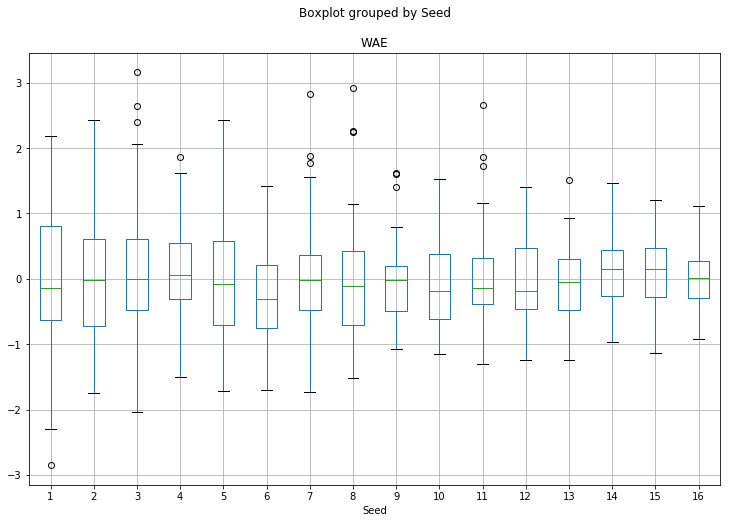

In [66]:
WAE.boxplot(column='WAE', by='Seed', figsize=(12,8))

In [67]:
ConfWAE = WAE.groupby('Conference').WAE.median()

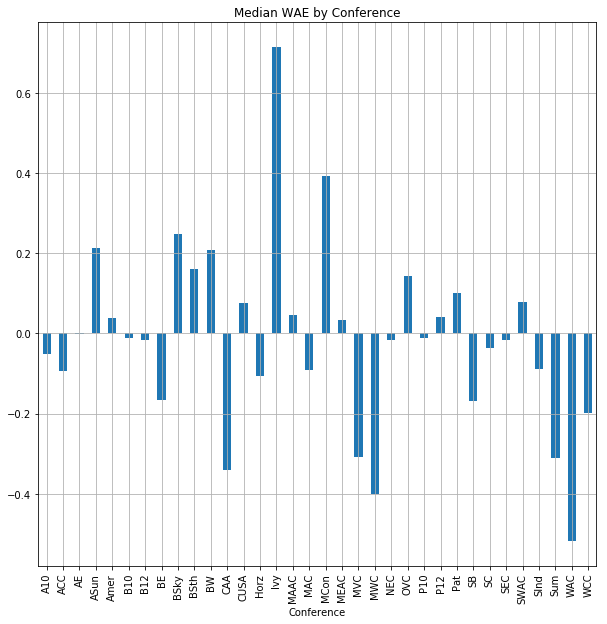

In [68]:
ConfWAE.plot(kind='bar',figsize=(10,10),grid=True, title='Median WAE by Conference')

In [69]:
# Ivy league is so high because they are usually expected negative wins
WAE[WAE.Conference == 'Ivy']

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
42,2003,Penn,11,0.0,-0.409039,Ivy,0.035,182,0.409039
120,2004,Princeton,14,0.0,-1.462712,Ivy,0.033,240,1.462712
180,2005,Penn,13,0.0,-0.824341,Ivy,0.034,187,0.824341
252,2006,Penn,15,0.0,-1.202008,Ivy,-0.030,254,1.202008
310,2007,Penn,14,0.0,-0.444758,Ivy,0.047,192,0.444758
380,2008,Cornell,14,0.0,-1.087220,Ivy,0.086,298,1.087220
444,2009,Cornell,14,0.0,-0.895763,Ivy,-0.005,281,0.895763
498,2010,Cornell,12,2.0,1.342501,Ivy,0.068,173,0.657499
571,2011,Princeton,13,0.0,0.202720,Ivy,0.091,166,-0.202720
628,2012,Harvard,12,0.0,0.181729,Ivy,0.027,175,-0.181729


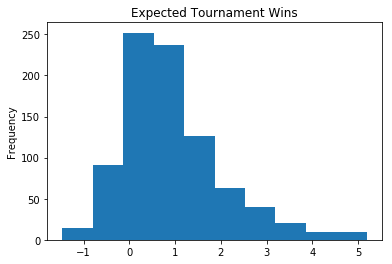

In [70]:
WAE.Expected.plot(kind='hist', title='Expected Tournament Wins')

## Bonus (2016-2017)

In [71]:
# just assess the elite 8 teams for the two years that I don't have kaggle data for

In [72]:
bonus.head()

,index,Year,Rank,Team,Team_Id,Conference,Wins,Losses,Seed,AdjustEM,...,Luck Rank,SOS AdjustEM,SOS AdjustEM Rank,SOS OppO,SOS OppO Rank,SOS OppD,SOS OppD Rank,NCSOS AdjustEM,NCSOS AdjustEM Rank,Tourn_wins
863,4437,2016,1,Villanova,1437,BE,35,5,2,32.01,...,114,10.74,13,110.5,19,99.7,9,2.98,83,0.0
864,4438,2016,2,North Carolina,1314,ACC,33,7,1,29.82,...,305,11.45,8,111.7,4,100.2,18,3.13,77,0.0
865,4439,2016,3,Kansas,1242,B12,33,5,1,29.67,...,75,12.61,3,111.4,8,98.8,4,3.62,66,0.0
866,4440,2016,4,Virginia,1438,ACC,29,8,1,29.64,...,278,12.67,2,112.1,2,99.5,6,4.98,38,0.0
867,4441,2016,5,Michigan St.,1277,B10,29,6,2,27.97,...,210,7.19,57,107.5,73,100.3,22,0.40,157,0.0


In [73]:
bonus['Expected'] = linreg.predict(bonus[features])

In [74]:
bonus_WAE = bonus[['Year','Team','Seed','Tourn_wins','Expected','Conference','Luck', 'SOS AdjustEM Rank']]

In [75]:
bonus_WAE['WAE'] = bonus_WAE.Tourn_wins - bonus_WAE.Expected

/Users/jamesbrideau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
bonus_WAE.head()

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
863,2016,Villanova,2,0.0,4.740079,BE,0.023,13,-4.740079
864,2016,North Carolina,1,0.0,3.794064,ACC,-0.055,8,-3.794064
865,2016,Kansas,1,0.0,4.173174,B12,0.044,3,-4.173174
866,2016,Virginia,1,0.0,3.088873,ACC,-0.040,2,-3.088873
867,2016,Michigan St.,2,0.0,2.394105,B10,-0.012,57,-2.394105


In [77]:
bonus_WAE[bonus_WAE.Team == 'Notre Dame'].index

Int64Index([894], dtype='int64')

In [78]:
bonus_WAE.set_value(863, 'Tourn_wins', 6) # villanova
bonus_WAE.set_value(864, 'Tourn_wins', 5) # carolina
bonus_WAE.set_value(887, 'Tourn_wins', 4) # syracuse
bonus_WAE.set_value(871, 'Tourn_wins', 4) # oklahoma
bonus_WAE.set_value(866, 'Tourn_wins', 3) # virginia
bonus_WAE.set_value(894, 'Tourn_wins', 3) # notre dame
bonus_WAE.set_value(865, 'Tourn_wins', 3) # kansas
bonus_WAE.set_value(873, 'Tourn_wins', 3) # oregon
bonus_WAE['WAE'] = bonus_WAE.Tourn_wins - bonus_WAE.Expected

/Users/jamesbrideau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [79]:
bonus_WAE.sort_values(by='WAE', ascending=False).head(20)

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
887,2016,Syracuse,10,4.0,1.557126,ACC,-0.027,18,2.442874
894,2016,Notre Dame,6,3.0,1.413364,ACC,0.054,12,1.586636
863,2016,Villanova,2,6.0,4.740079,BE,0.023,13,1.259921
864,2016,North Carolina,1,5.0,3.794064,ACC,-0.055,8,1.205936
871,2016,Oklahoma,2,4.0,3.043838,B12,0.082,1,0.956162
901,2016,Yale,12,0.0,-0.326058,Ivy,0.026,169,0.326058
925,2016,Florida Gulf Coast,16,0.0,-0.288369,ASun,-0.038,285,0.288369
919,2016,Cal St. Bakersfield,15,0.0,-0.218347,WAC,-0.003,302,0.218347
873,2016,Oregon,1,3.0,2.853095,P12,0.041,33,0.146905
922,2016,UNC Asheville,15,0.0,-0.060420,BSth,-0.008,248,0.060420


In [80]:
# Syracuse was by far the biggest surprise in the final four while Kansas actually underperformed
# by making it to the Elite Eight

In [81]:
WAE[WAE.Tourn_wins == 6]

,Year,Team,Seed,Tourn_wins,Expected,Conference,Luck,SOS AdjustEM Rank,WAE
7,2003,Syracuse,3,6.0,2.842235,BE,0.083,10,3.157765
66,2004,Connecticut,2,6.0,3.575630,BE,0.012,18,2.424370
130,2005,North Carolina,1,6.0,4.588406,ACC,0.011,2,1.411594
195,2006,Florida,3,6.0,3.355178,SEC,-0.011,24,2.644822
261,2007,Florida,1,6.0,3.974027,SEC,0.028,33,2.025973
325,2008,Kansas,1,6.0,4.952560,B12,0.012,14,1.047440
390,2009,North Carolina,1,6.0,4.190289,ACC,-0.011,24,1.809711
455,2010,Duke,1,6.0,5.119263,ACC,0.009,4,0.880737
529,2011,Connecticut,3,6.0,3.941417,BE,0.048,2,2.058583
589,2012,Kentucky,1,6.0,4.784994,SEC,0.032,26,1.215006
